In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, IBMQ
from qiskit.circuit import Gate, Parameter
from qiskit.circuit.barrier import Barrier
from qiskit import schedule as build_schedule
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging

from pulse_experiment_utils import *

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider_utokyo = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
provider_ibmr = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
lagos = provider_ibmr.get_backend('ibm_lagos')
kawasaki = provider_utokyo.get_backend('ibm_kawasaki')
#backend = provider.get_backend('ibmq_guadalupe')
#backend = provider.get_backend('ibmq_bogota')
#backend = provider.get_backend('ibmq_toronto')

In [5]:
phi_values = np.linspace(-np.pi, np.pi, 41)

In [6]:
backend_config = kawasaki.configuration()
backend_defaults = kawasaki.defaults()
calibrations = backend_defaults.instruction_schedule_map

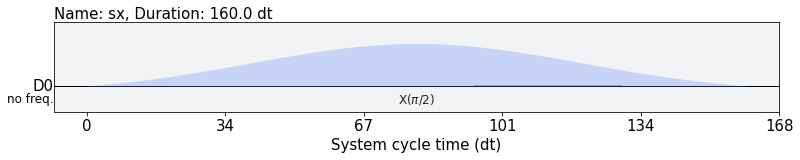

In [7]:
x_schedule = calibrations.get('x', [0])
x_pulse = x_schedule.instructions[0][1].pulse
sx_schedule = calibrations.get('sx', [0])
sx_pulse = sx_schedule.instructions[0][1].pulse
cx_schedule = calibrations.get('cx', (0, 1))
sx_schedule.draw()

# Sweep phase shifts before $X$ and $\sqrt{X}$ gates

schedules = []

for phi_value in phi_values:
    with pulse.build(backend=kawasaki, default_alignment='sequential') as sched:
        channel = pulse.drive_channel(0)
        pulse.shift_phase(phi_value, channel)
        pulse.play(x_pulse, channel)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    schedules.append(sched)
    
for phi_value in phi_values:
    with pulse.build(backend=kawasaki, default_alignment='sequential') as sched:
        channel = pulse.drive_channel(0)
        pulse.shift_phase(phi_value, channel)
        pulse.play(sx_pulse, channel)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    schedules.append(sched)

job = kawasaki.run(schedules, meas_level=2, shots=8192)
job_monitor(job)

In [6]:
circuits = []

for phi_value in phi_values:
    circuit = QuantumCircuit(1)
    circuit.rz(phi_value, 0)
    circuit.x(0)
    circuit.measure_all()
    
    circuits.append(circuit)
    
for phi_value in phi_values:
    circuit = QuantumCircuit(1)
    circuit.rz(phi_value, 0)
    circuit.sx(0)
    circuit.measure_all()
    
    circuits.append(circuit)

In [6]:
job = lagos.run(transpile(circuits, backend=lagos), shots=8192)
job_monitor(job)

Job Status: job has successfully run


In [6]:
job = lagos.retrieve_job('614201d76feb7e09056f5ca5')
result = job.result()

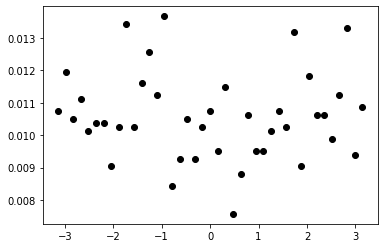

array([0.01074219, 0.01196289, 0.01049805, 0.0111084 , 0.01013184,
       0.01037598, 0.01037598, 0.0090332 , 0.01025391, 0.01342773,
       0.01025391, 0.01159668, 0.01257324, 0.01123047, 0.01367188,
       0.00842285, 0.00927734, 0.01049805, 0.00927734, 0.01025391,
       0.01074219, 0.00952148, 0.01147461, 0.00756836, 0.00878906,
       0.01062012, 0.00952148, 0.00952148, 0.01013184, 0.01074219,
       0.01025391, 0.01318359, 0.0090332 , 0.01184082, 0.01062012,
       0.01062012, 0.0098877 , 0.01123047, 0.01330566, 0.00939941,
       0.01086426])

In [7]:
plot_counts(result, ['0'], phi_values, indices=np.arange(phi_values.shape[0]))

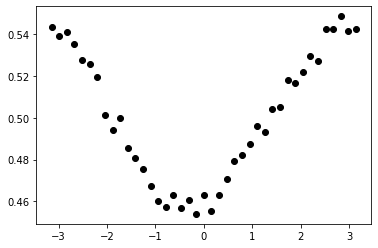

array([0.54345703, 0.53930664, 0.54101562, 0.53552246, 0.52783203,
       0.52575684, 0.51940918, 0.50134277, 0.4942627 , 0.49975586,
       0.48571777, 0.48059082, 0.47570801, 0.46740723, 0.46020508,
       0.45751953, 0.46313477, 0.45703125, 0.46057129, 0.45397949,
       0.46289062, 0.45556641, 0.46289062, 0.47045898, 0.47937012,
       0.48217773, 0.48754883, 0.49609375, 0.49316406, 0.50402832,
       0.50537109, 0.51818848, 0.5168457 , 0.52197266, 0.52954102,
       0.52697754, 0.5423584 , 0.5423584 , 0.54858398, 0.54174805,
       0.5423584 ])

In [8]:
plot_counts(result, ['0'], phi_values, indices=np.arange(phi_values.shape[0], 2 * phi_values.shape[0]))

job = kawasaki.retrieve_job('614200839664977d03f654a3')
result = job.result()

plot_counts(result, ['0'], indices=np.arange(40))

plot_counts(result, ['0'], indices=np.arange(40, 80))

In [8]:
circuits = []
for phi_value in phi_values:
    circuit = QuantumCircuit(1)
    circuit.sx(0)
    circuit.rz(phi_value, 0)
    circuit.sx(0)
    circuit.measure_all()
    circuits.append(circuit)

In [ ]:
job = lagos.run(transpile(circuits, backend=lagos), shots=8192)
job_monitor(job)

In [11]:
job = kawasaki.retrieve_job('614205cc10b4a22223a0f135')

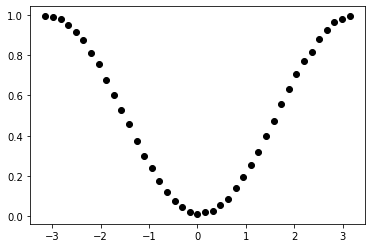

In [12]:
yvalues = plot_counts(job.result(), ['0'], x=phi_values)

[0.9994565  3.08547334 0.49110603 0.50303209]


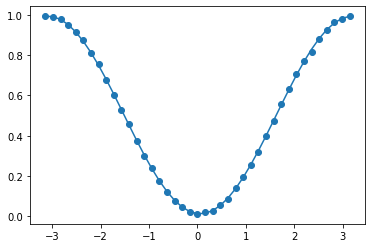

In [16]:
fun = lambda x, omega, p, a, o: o + a * np.cos(x * omega + p)
popt, _ = scipy.optimize.curve_fit(fun, phi_values, yvalues, p0=[1., np.pi, 0.5, 0.5])
print(popt)
plt.scatter(phi_values, yvalues)
plt.plot(phi_values, fun(phi_values, *popt))